### aim: check inconsistency between pyCDFtools and fortran:

pycdftools:

https://github.com/julianmak/NEMO-related/tree/master/pyCDFTOOLS

original fortran:

https://github.com/meom-group/CDFTOOLS



In [29]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [30]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [31]:
# import numpy as np
from cmocean import cm
# import cartopy as cp
# import cartopy.crs as ccrs
# import netCDF4 as nc
import matplotlib.pyplot as plt
# import xarray as xr
# import sys
# sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
# #list of models
# sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
# import lom
# import utils as ut

%matplotlib inline
import warnings
#from datetime import datetime
warnings.filterwarnings('ignore')
# import cartopy.feature as cfeature
# from importlib import reload
# import matplotlib.path as mpath
# import glob
# import pickle
# import pandas as pd
# import seawater
# import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

import xarray as xr

## run CDFTOOLS locally on a v velocity output file:

    /gpfs/home/mep22dku/scratch/SOZONE/CDFTOOLS/src

    ~/scratch/SOZONE/CDFTOOLS/bin]$ ./cdfmoc -v TOM12_TJ_GNA2_ORCA2_1m_19400101_19401231_grid_V.nc

    mv moc.nc TOM12_TJ_GNA2_ORCA2_1m_19400101_19401231_moc.nc
    
    

Text(0.5, 1.0, 'Global depth-coordinate overturning, calc with cdfmoc \n Sv, GNA2 run, year 1940, month 1')

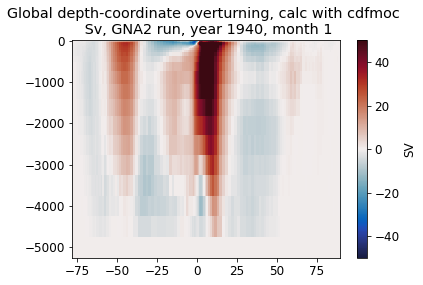

In [32]:

moc_cdf = xr.open_dataset('/gpfs/home/mep22dku/scratch/SOZONE/CDFTOOLS/bin/TOM12_TJ_GNA2_ORCA2_1m_19400101_19401231_moc.nc')

#moc_cdf
time_ind = 0
q = plt.pcolormesh(moc_cdf.nav_lat[:,0], moc_cdf.depthw, moc_cdf.zomsfglo[time_ind,:,:,0], \
              vmin = -50, vmax = 50, cmap = cm.balance)
plt.colorbar(q, label = 'SV')
plt.title(f'Global depth-coordinate overturning, calc with cdfmoc \n Sv, GNA2 run, year 1940, month {time_ind+1}')

In [33]:
from numba import jit
from numpy import zeros, argmax, unravel_index
from netCDF4 import Dataset

def cdfmoc(data_dir, v_file, v_var, **kwargs):
  """
  Compute the MOC in depth co-ordinates

  Needs associated mesh_mask.nc file in the same data folder
  
  Inputs:
    data_dir = string for data directory
    v_file   = string for file with v in
    v_var    = string for v variable name
  
  Optional arguments (as of 16 Apr 2018):
    lprint   = True   for printing out variable names in netcdf file
    lg_vvl   = True   for using s-coord (time-varying metric)
    ldec     = True   decompose the MOC into some components
    lbas     = True   decompose the MOC into basins (need a new_maskglo.nc with default variable names)
    leiv     = True   for adding the eddy induced velocity component
      eivv_var = string for EIV-v variable name
    
  Returns:
    zW (gdepw_1d), latV (rdumlat), dmoc for plotting, opt_dic for record
  """
  # some defaults for optional arguments
  opt_dic = {"kt"     : 0,
             "lprint" : False,
             "lg_vvl" : False,
             "ldec"   : False,
             "lbas"   : False,
             "leiv"   : False}

  # overwrite the options by cycling through the input dictionary
  for key in kwargs:
    opt_dic[key] = kwargs[key]

  # open some files and pull variables out
  cf_vfil = Dataset(data_dir + v_file)
  if opt_dic["lprint"]:
    print(cf_vfil)
  npiglo  = len(cf_vfil.dimensions["x"])
  npjglo  = len(cf_vfil.dimensions["y"])
  npk     = len(cf_vfil.dimensions["depthv"])
  zv      = cf_vfil.variables[v_var][opt_dic["kt"], :, :, :]
  if opt_dic["lg_vvl"]:
    e3v     = cf_vfil.variables["e3v"][opt_dic["kt"], :, :, :]
  if opt_dic["leiv"]:
    # load and add the contribution to zv
    zeiv    = cf_vfil.variables[opt_dic["eivv_var"]][opt_dic["kt"], :, :, :]
    zv += zeiv
  cf_vfil.close()
  
  cn_mask = Dataset(data_dir + "mesh_mask.nc")
  e1v     = cn_mask.variables["e1v"][0, :, :]
  gphiv   = cn_mask.variables["gphiv"][0, :, :]
  gdepw   =-cn_mask.variables["gdepw_1d"][0, :]
  vmask   = cn_mask.variables["vmask"][0, :, :, :]
  if not opt_dic["lg_vvl"]:
    e3v     = cn_mask.variables["e3v_0"][opt_dic["kt"], :, :, :]
  cn_mask.close()
  
  if opt_dic["lbas"]:
    # 0 : global ; 1 : Atlantic ; 2 : Indo-Pacif ; 3 : Indian ; 4 : Pacif
    cn_basin = Dataset(data_dir + "new_maskglo.nc")
    nbasins = 5
    ibmask = zeros((nbasins, npjglo, npiglo))
    ibmask[0, :, :] = vmask[0, :, :]
    ibmask[1, :, :] = cn_basin.variables["atlmsk"][:, :]
    ibmask[2, :, :] = cn_basin.variables["indpacmsk"][:, :]
    ibmask[3, :, :] = cn_basin.variables["indmsk"][:, :]
    ibmask[4, :, :] = cn_basin.variables["pacmsk"][:, :]
    cn_basin.close()
  else:
    nbasins = 1
    ibmask = zeros((nbasins, npjglo, npiglo))
    ibmask[0, :, :] = vmask[0, :, :]
    
  if opt_dic["ldec"]:
    print("NOT DONE THIS YET! -- 16 APR 2018")
    return (0.0, 0.0, 0.0, opt_dic)

#  --------------------------
#  0) Create a dummy latitude to output
#  --------------------------
  iloc = unravel_index(argmax(gphiv, axis = None), gphiv.shape)
  rdumlat = gphiv[:, iloc[1]]
  
#  --------------------------
#  1) Compute total MOC: dmoc 
#     [loop done using jit to speed it up (about 60 times faster)]
#  --------------------------
  dmoc = dmoc_loop(e1v, e3v, vmask, zv, npk, npjglo, npiglo, ibmask)

  return (gdepw, rdumlat, dmoc, opt_dic)
  
#-------------------------------------------------------------------------------

@jit(nopython = True)
def dmoc_loop(e1v, e3v, vmask, zv, npk, npjglo, npiglo, ibmask):

  dmoc = zeros((ibmask.shape[0], npk, npjglo))
  
  zv *= vmask # mask the array here
  
  # integrate 'zonally' (along i-coordinate)
  for jbasin in range(ibmask.shape[0]):
    for jk in range(npk):
      for jj in range(npjglo):
        for ji in range(npiglo):
          if ibmask[jbasin, jj, ji]:
            dmoc[jbasin, jk, jj] -= e1v[jj, ji] * e3v[jk, jj, ji] * zv[jk, jj, ji]
        
  # integrate vertically from bottom to surface
  for jj in range(npjglo):
    for jk in range(npk-2, 0, -1): # python indexing
      dmoc[:, jk, jj] = dmoc[:, jk + 1, jj] + dmoc[:, jk, jj] / 1.0e6
      
  return dmoc

## dmoc calculation in original fortran:

https://github.com/meom-group/CDFTOOLS/blob/master/src/cdftools.f90

  DO jt = 1, npt
     IF ( lg_vvl ) THEN  ; it=jt
     ELSE                ; it=1
     ENDIF

     IF ( it == jt ) THEN
        DO jk= 1, npk
           ! save e3v masked with vmask as 3d array
           e3v(:,:,jk) = get_e3v(jk,it)
        END DO
     ENDIF
     ! --------------------------
     ! 1) Compute total MOC: dmoc
     ! --------------------------
     dmoc(:,:,:) = 0.d0        ! initialize moc to 0
     IF ( ldec) THEN ; dvbt=0.d0 ; hdep=0.0 ; dmoc_bt=0.d0 ;
     ENDIF
     DO jk = 1, npk-1
        ! Get velocities v at jk, time = jt
        zv(:,:)= getvar(cf_vfil, cn_vomecrty,  jk, npiglo, npjglo, ktime=jt)
        !          print *, jk, MAXVAL(zv)

        IF ( ldec ) THEN
           ! compute barotropic component when requested
           ! this contribution is computed here in order to use zv(jk)
           dvbt(:,:)    = dvbt(:,:) + e3v(:,:,jk)*zv(:,:)*1.d0
           hdep(:,:)    = hdep(:,:) + e3v(:,:,jk)
        ENDIF

        ! integrates 'zonally' (along i-coordinate)
        DO jbasin = 1, nbasins
           !$OMP PARALLEL DO SCHEDULE(RUNTIME)
           DO jj=1,npjglo
              DO ji=1,npiglo
                 ! For all basins 
                 dmoc(jbasin,jj,jk)=dmoc(jbasin,jj,jk) -  &
                      &             e1v(ji,jj)*e3v(ji,jj,jk)* ibmask(jbasin,ji,jj)*zv(ji,jj)*1.d0
              ENDDO
           END DO
           !$OMP END PARALLEL DO
        END DO
     END DO

     ! integrates vertically from bottom to surface
     !$OMP PARALLEL DO SCHEDULE(RUNTIME)
     DO jj = 1, npjglo
        DO jk = npk-1, 1, -1
           dmoc(:,jj,jk)    = dmoc(:,jj,jk+1)    + dmoc(:,jj,jk)/1.d6
        END DO
     ENDDO
     !$OMP END PARALLEL DO

## same calc on same file with pyCDFtools (mesh mask also the same)

In [57]:
(gdepw, rdumlat, dmoc, opt_dic) = cdfmoc('/gpfs/home/mep22dku/scratch/SOZONE/CDFTOOLS/bin/',\
                'TOM12_TJ_GNA2_ORCA2_1m_19400101_19401231_grid_V.nc', 'vomecrty')

In [38]:
import numpy as np
print(np.shape(dmoc))

(1, 31, 149)


Text(0.5, 1.0, 'difference')

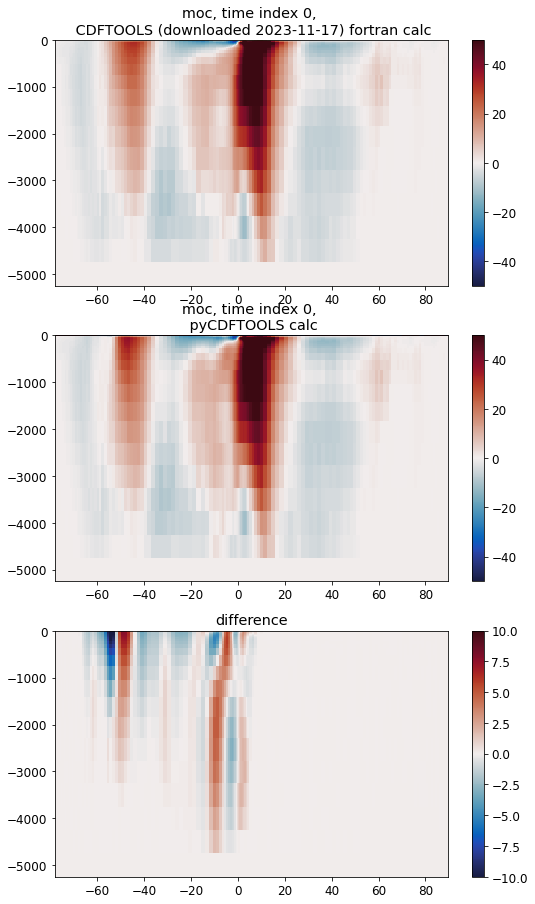

In [58]:
fact = 1.1
fig, axs = plt.subplots(3,1, figsize=(8*fact, 14*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

time_ind = 0
q = axs[0].pcolormesh(moc_cdf.nav_lat[:,0], moc_cdf.depthw, moc_cdf.zomsfglo[time_ind,:,:,0], \
              vmin = -50, vmax = 50, cmap = cm.balance)
plt.colorbar(q, ax = axs[0])
axs[0].set_title('moc, time index 0, \n CDFTOOLS (downloaded 2023-11-17) fortran calc')

#gdepw, rdumlat, dmoc,
q = axs[1].pcolormesh(moc_cdf.nav_lat[:,0], gdepw, dmoc[0,:,:], \
              vmin = -50, vmax = 50, cmap = cm.balance)
plt.colorbar(q, ax = axs[1])
axs[1].set_title('moc, time index 0, \n pyCDFTOOLS calc')


q = axs[2].pcolormesh(moc_cdf.nav_lat[:,0], gdepw, dmoc[0,:,:]-moc_cdf.zomsfglo[time_ind,:,:,0], \
              vmin = -10, vmax = 10, cmap = cm.balance)
plt.colorbar(q, ax = axs[2])
axs[2].set_title('difference')



In [54]:
from numba import jit
from numpy import zeros, argmax, unravel_index
from netCDF4 import Dataset

def cdfmoc2(data_dir, v_file, v_var, **kwargs):
  """
  Compute the MOC in depth co-ordinates

  Needs associated mesh_mask.nc file in the same data folder
  
  Inputs:
    data_dir = string for data directory
    v_file   = string for file with v in
    v_var    = string for v variable name
  
  Optional arguments (as of 16 Apr 2018):
    lprint   = True   for printing out variable names in netcdf file
    lg_vvl   = True   for using s-coord (time-varying metric)
    ldec     = True   decompose the MOC into some components
    lbas     = True   decompose the MOC into basins (need a new_maskglo.nc with default variable names)
    leiv     = True   for adding the eddy induced velocity component
      eivv_var = string for EIV-v variable name
    
  Returns:
    zW (gdepw_1d), latV (rdumlat), dmoc for plotting, opt_dic for record
  """
  # some defaults for optional arguments
  opt_dic = {"kt"     : 0,
             "lprint" : False,
             "lg_vvl" : False,
             "ldec"   : False,
             "lbas"   : False,
             "leiv"   : False}

  # overwrite the options by cycling through the input dictionary
  for key in kwargs:
    opt_dic[key] = kwargs[key]

  # open some files and pull variables out
  cf_vfil = Dataset(data_dir + v_file)
  if opt_dic["lprint"]:
    print(cf_vfil)
  npiglo  = len(cf_vfil.dimensions["x"])
  npjglo  = len(cf_vfil.dimensions["y"])
  npk     = len(cf_vfil.dimensions["depthv"])
  zv      = cf_vfil.variables[v_var][opt_dic["kt"], :, :, :]
  if opt_dic["lg_vvl"]:
    e3v     = cf_vfil.variables["e3v"][opt_dic["kt"], :, :, :]
  if opt_dic["leiv"]:
    # load and add the contribution to zv
    zeiv    = cf_vfil.variables[opt_dic["eivv_var"]][opt_dic["kt"], :, :, :]
    zv += zeiv
  cf_vfil.close()
  
  cn_mask = Dataset(data_dir + "mesh_mask.nc")
  e1v     = cn_mask.variables["e1v"][0, :, :]
  gphiv   = cn_mask.variables["gphiv"][0, :, :]
  gdepw   =-cn_mask.variables["gdepw_1d"][0, :]
  vmask   = cn_mask.variables["vmask"][0, :, :, :]
  if not opt_dic["lg_vvl"]:
    e3v     = cn_mask.variables["e3v_0"][opt_dic["kt"], :, :, :]
  cn_mask.close()
  
  if opt_dic["lbas"]:
    # 0 : global ; 1 : Atlantic ; 2 : Indo-Pacif ; 3 : Indian ; 4 : Pacif
    cn_basin = Dataset(data_dir + "new_maskglo.nc")
    nbasins = 5
    ibmask = zeros((nbasins, npjglo, npiglo))
    ibmask[0, :, :] = vmask[0, :, :]
    ibmask[1, :, :] = cn_basin.variables["atlmsk"][:, :]
    ibmask[2, :, :] = cn_basin.variables["indpacmsk"][:, :]
    ibmask[3, :, :] = cn_basin.variables["indmsk"][:, :]
    ibmask[4, :, :] = cn_basin.variables["pacmsk"][:, :]
    cn_basin.close()
  else:
    nbasins = 1
    ibmask = zeros((nbasins, npjglo, npiglo))
    ibmask[0, :, :] = vmask[0, :, :]
    
  if opt_dic["ldec"]:
    print("NOT DONE THIS YET! -- 16 APR 2018")
    return (0.0, 0.0, 0.0, opt_dic)

#  --------------------------
#  0) Create a dummy latitude to output
#  --------------------------
  iloc = unravel_index(argmax(gphiv, axis = None), gphiv.shape)
  rdumlat = gphiv[:, iloc[1]]
  
#  --------------------------
#  1) Compute total MOC: dmoc 
#     [loop done using jit to speed it up (about 60 times faster)]
#  --------------------------
  dmoc = dmoc_loop2(e1v, e3v, vmask, zv, npk, npjglo, npiglo, ibmask)

  return (gdepw, rdumlat, dmoc, opt_dic)
  
#-------------------------------------------------------------------------------

@jit(nopython = True)
def dmoc_loop2(e1v, e3v, vmask, zv, npk, npjglo, npiglo, ibmask):

  dmoc = zeros((ibmask.shape[0], npk, npjglo))
  
  zv *= vmask # mask the array here
  
  # integrate 'zonally' (along i-coordinate)
  for jbasin in range(ibmask.shape[0]):
    for jk in range(npk):
      for jj in range(npjglo):
        for ji in range(npiglo):
          if ibmask[jbasin, jj, ji]:
            dmoc[jbasin, jk, jj] -= e1v[jj, ji] * e3v[jk, jj, ji] * zv[jk, jj, ji]
        
  # integrate vertically from bottom to surface
  for jj in range(npjglo):
    for jk in range(npk-2, -1, -1): # python indexing
      print(jk)
      dmoc[:, jk, jj] = dmoc[:, jk + 1, jj] + dmoc[:, jk, jj] / 1.0e6

    # ! integrates vertically from bottom to surface
    #  !$OMP PARALLEL DO SCHEDULE(RUNTIME)
    #  DO jj = 1, npjglo
    #     DO jk = npk-1, 1, -1
    #        dmoc(:,jj,jk)    = dmoc(:,jj,jk+1)    + dmoc(:,jj,jk)/1.d6
    #     END DO
    #  ENDDO
    #  !$OMP END PARALLEL DO
    
  return dmoc

In [56]:
(gdepw, rdumlat, dmoc2, opt_dic) = cdfmoc2('/gpfs/home/mep22dku/scratch/SOZONE/CDFTOOLS/bin/',\
                'TOM12_TJ_GNA2_ORCA2_1m_19400101_19401231_grid_V.nc', 'vomecrty')

29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0
29
28
27
26
25
24
23
22
21
20
19
18
17
1

Text(0.5, 1.0, 'difference')

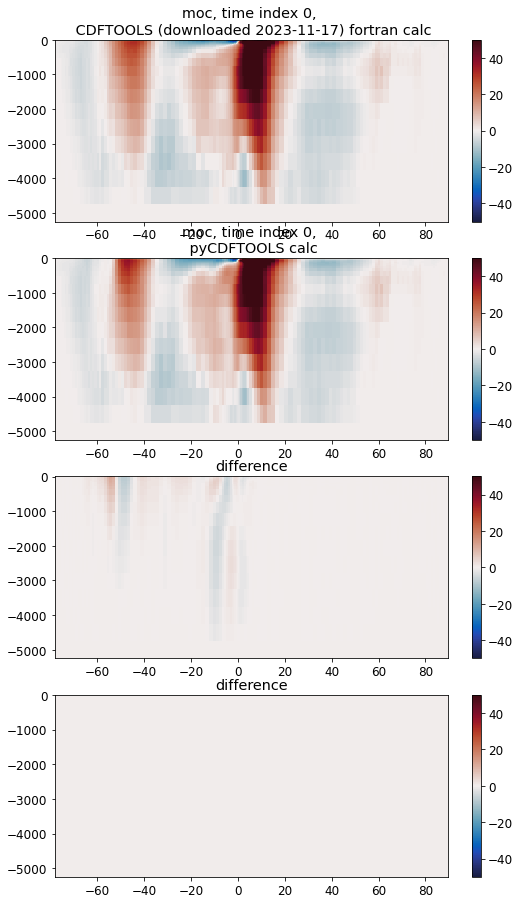

In [73]:
fact = 1.1
fig, axs = plt.subplots(4,1, figsize=(8*fact, 14*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

time_ind = 0
q = axs[0].pcolormesh(moc_cdf.nav_lat[:,0], moc_cdf.depthw, moc_cdf.zomsfglo[time_ind,:,:,0], \
              vmin = -50, vmax = 50, cmap = cm.balance)
plt.colorbar(q, ax = axs[0])
axs[0].set_title('moc, time index 0, \n CDFTOOLS (downloaded 2023-11-17) fortran calc')

#gdepw, rdumlat, dmoc,
q = axs[1].pcolormesh(moc_cdf.nav_lat[:,0], gdepw, dmoc[0,:,:], \
              vmin = -50, vmax = 50, cmap = cm.balance)
plt.colorbar(q, ax = axs[1])
axs[1].set_title('moc, time index 0, \n pyCDFTOOLS calc')


# q = axs[2].pcolormesh(moc_cdf.nav_lat[:,0], gdepw, dmoc[0,:,:]-moc_cdf.zomsfglo[time_ind,:,:,0], \
#               vmin = -10, vmax = 10, cmap = cm.balance)
q = axs[2].pcolormesh(moc_cdf.nav_lat[:,0], gdepw, moc_cdf.zomsfglo[time_ind,:,:,0]-dmoc2[0,:,:], \
              vmin = -50, vmax = 50, cmap = cm.balance)
plt.colorbar(q, ax = axs[2])
axs[2].set_title('difference')

q = axs[3].pcolormesh(moc_cdf.nav_lat[:,0], gdepw, dmoc2[0,:,:]-dmoc[0,:,:], \
              vmin = -50, vmax = 50, cmap = cm.balance)
plt.colorbar(q, ax = axs[3])
axs[3].set_title('difference')


In [67]:
print(np.nanmax(dmoc2[0,:,:]-dmoc[0,:,:]))

print(np.nanmax(dmoc2[0,:,:]-moc_cdf.zomsfglo[time_ind,:,:,0]))

24669123.569689155
7.678134595323286


In [70]:
print(np.shape(dmoc2))

(1, 31, 149)


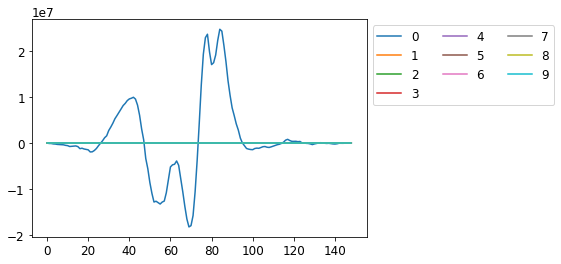

In [72]:
for i in range(0,10):
    plt.plot((dmoc2[0,i,:]-dmoc[0,i,:]), label = f'{i}')
    
plt.legend(ncol = 3, bbox_to_anchor = [1,1])